In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:\\Users\\Amir Hossein\\Downloads\\hyperparameters_2moons_results.csv", header=0, index_col=None)
df['val_metrics'] = df['val_metrics'].apply(lambda x: float(str(x).replace('tensor(', '').replace(')', '')))
df = df.where(df['l2_lambda'] <= 1)
df = df.groupby(['d', 'l2_lambda'])[['val_loss', 'val_metrics']].mean().reset_index()
df.head()

,d,l2_lambda,val_loss,val_metrics
0,1.0,0.000001,0.521844,0.74644
1,1.0,0.000002,0.561021,0.75703
2,1.0,0.000004,0.552522,0.74592
3,1.0,0.000009,0.567387,0.74977
4,1.0,0.000010,0.498630,0.75642


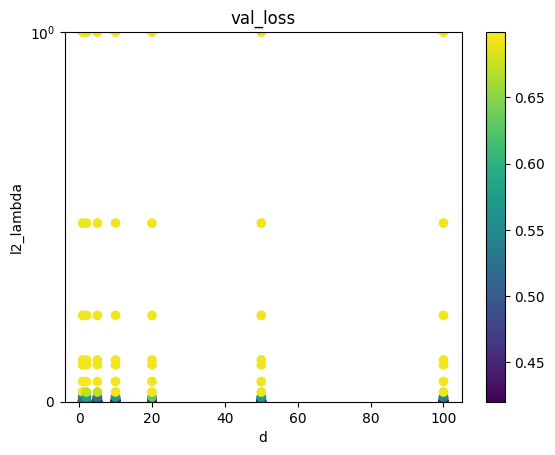

In [3]:
fig, ax = plt.subplots()
scatter = ax.scatter(df['d'], df['l2_lambda'], c=df['val_loss'], cmap='viridis')
ax.set_yscale('symlog')
ax.set_xlabel('d')
ax.set_ylabel('l2_lambda')
ax.set_ylim(0, 1)
ax.set_title('val_loss')
cbar = fig.colorbar(scatter, ax=ax)
plt.show()

In [4]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(
    x=df['d'],
    y=df['l2_lambda'],
    mode='markers',
    marker=dict(
        size=7.5,
        color=df['val_loss'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='val_loss')
    ),
    text=df['val_loss'],  # Add this line to show val_loss on hover
    hovertemplate='val_loss: %{text}<extra></extra>'  # Customize the hover text
))
fig.update_layout(
    title='val_loss',
    xaxis=dict(title='d'),
    yaxis=dict(title='l2_lambda', type='log')
)
fig.show()
fig.write_image("2moons.png")